In [1]:
import warnings

import matplotlib.patheffects as pe
import plot_gwr
import utils
from matplotlib.colors import Normalize, TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- Imports ---
from my_packages import *

In [6]:
# --- 1. File Paths ---
FEATHER_FILE_PATH = r"D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\3L_TestRun_6_GWR_AllKernels\GWR_Prediction_Output\GWR_Layer_4.feather"
utils.setup_font(r"fonts/verdana.ttf")

# --- 2. Data Column Names ---
# (These are now used only for coordinates and time)
DATETIME_STRING_COLUMN = "datetime_str"
DATETIME_OBJECT_COLUMN = "datetime"
X_COORD_COLUMN = "X_TWD97"
Y_COORD_COLUMN = "Y_TWD97"

# --- 3. Coordinate Reference Systems (CRS) ---
SOURCE_CRS = "EPSG:3826"
DISPLAY_CRS = "EPSG:4326"

# --- 4. NEW: Processing & Plotting Configuration ---

# --- PCOLORMESH (Fill) Settings ---
# 'source_col': Name of column in feather file
# 'operation': 'mean', 'std', 'median', or 'first' (for static data)

# PCOLORMESH_CONFIG = {"source_col": "DIFFDISP_coef", "operation": "mean"}
PCOLORMESH_CONFIG = {"source_col": "prediction", "operation": "mean"}
COLORBAR_LABEL = "GWR Average Spatial Prediction"  # Label for the pcolormesh

# --- CONTOUR (Line) Settings ---
PLOT_CONTOURS = False  # <-- Your main switch

# --- SCENARIO 1: Mean (pcolor) and Std (contour) of SAME variable ---
# (This implements your request)
CONTOUR_CONFIG = {
    "source_col": "prediction",  # <-- Same variable as pcolormesh
    "operation": "std",  # <-- Different operation
}
CONTOUR_LEVELS = 10  # 10 automatic levels for the std deviation
# CONTOUR_LEVELS = np.arange(
#     0, 1, 0.05
# )  # 10 automatic levels for the std deviation

# --- SCENARIO 2: Mean (pcolor) and Mean (contour) of DIFFERENT variables ---
# (This is how you would plot a different variable)
# PCOLORMESH_CONFIG = {
#     "source_col": "DIFFDISP_coef",
#     "operation": "mean"
# }
# CONTOUR_CONFIG = {
#     "source_col": "Intercept_coef", # <-- Different variable
#     "operation": "mean"           # <-- Same operation
# }
# CONTOUR_LEVELS = 10 # 10 automatic levels for the Intercept_coef mean

CONTOUR_LINE_COLOR = "black"
CONTOUR_HALO_SIZE = 3
CONTOUR_HALO_COLOR = "white"


# --- 5. Visualization Parameters (Pcolormesh) ---
PLOT_FIGSIZE = (10, 10)
MAP_SCALE = None

# change this when plotting intercept or deformation
USE_DIVERGING_NORM = True

# --- Sequential Map Settings (if USE_DIVERGING_NORM = False) ---
PLOT_CMAP_SEQ = "BuPu"
PLOT_VMIN_SEQ = 0.0
PLOT_VMAX_SEQ = 0.4

# --- Diverging Map Settings (if USE_DIVERGING_NORM = True) ---
PLOT_CMAP_DIV = "RdBu"
PLOT_VMIN_DIV = -0.301
PLOT_VMAX_DIV = 0.301
PLOT_VCENTER_DIV = 0.0

# --- Colorbar Halo Settings ---
USE_TEXT_HALO = True
HALO_SIZE = 3
HALO_COLOR = "white"


print("Configuration set.")

Successfully loaded font: Verdana
Configuration set.


Loading data from D:\1000_SCRIPTS\003_Project002\20250917_GTWR002\3L_TestRun_6_GWR_AllKernels\GWR_Prediction_Output\GWR_Layer_4.feather...

Available columns: ['PointKey', 'X_TWD97', 'Y_TWD97', 'monthly', 'datetime', 'datetime_str', 'DIFFDISP', 'Intercept_coef', 'DIFFDISP_coef', 'prediction', 'prediction_var', 'prediction_std']

Converting DataFrame to xarray DataCube...
DataCube successfully created from DataFrame.
Processing 'prediction' with operation 'mean' for pcolormesh.
Merging processed layers into a single Dataset...
Renaming spatial dimensions from 'X_TWD97'/'Y_TWD97' to 'x'/'y'...
Writing source CRS: EPSG:3826
Setting spatial dimensions for rioxarray...
Reprojecting from EPSG:3826 to EPSG:4326...
xarray dataset created and reprojected.

DEBUGGING PROCESSED DATASET:
<xarray.Dataset> Size: 926kB
Dimensions:          (x: 310, y: 371)
Coordinates:
  * x                (x) float64 2kB 120.1 120.1 120.1 ... 120.7 120.7 120.7
  * y                (y) float64 3kB 24.2 24.19 24.19 ..

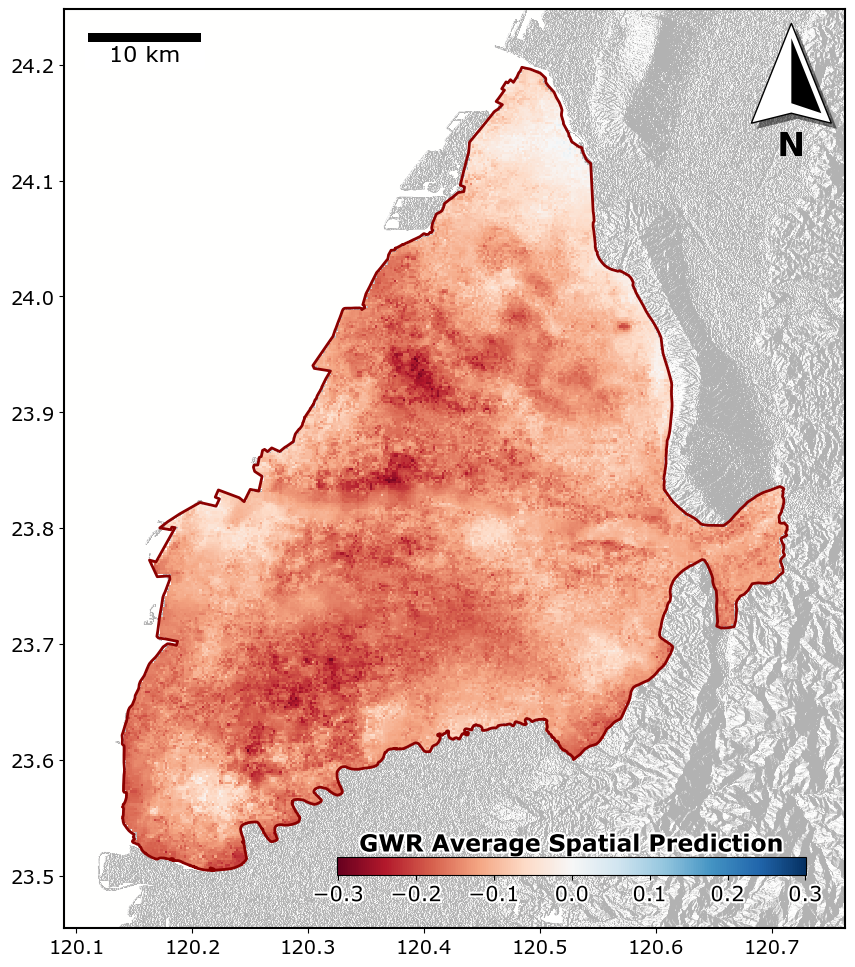

In [7]:
# 1. Load and process the input data
processed_df = plot_gwr.load_and_preprocess_data(
    filepath=FEATHER_FILE_PATH,
    datetime_str_col=DATETIME_STRING_COLUMN,
    datetime_obj_col=DATETIME_OBJECT_COLUMN,
)

# --- Add this line to see all available columns ---
print("\n" + "=" * 50)
print(f"Available columns: {processed_df.columns.tolist()}")
print("=" * 50 + "\n")


# 2. Convert DataFrame to a processed xarray Dataset
reprojected_ds = plot_gwr.create_xarray_dataset(
    df=processed_df,
    time_col=DATETIME_OBJECT_COLUMN,
    x_col=X_COORD_COLUMN,
    y_col=Y_COORD_COLUMN,
    source_crs=SOURCE_CRS,
    display_crs=DISPLAY_CRS,
    pcolormesh_config=PCOLORMESH_CONFIG,  # <-- Pass the new config
    plot_contours=PLOT_CONTOURS,
    contour_config=CONTOUR_CONFIG,  # <-- Pass the new config
)

# --- DEBUGGING STEP ---
if reprojected_ds is None:
    print("ERROR: Dataset creation failed. Check config and file.")
else:
    print("\n" + "=" * 30)
    print("DEBUGGING PROCESSED DATASET:")
    print(reprojected_ds)  # This will show 'pcolormesh_data' and 'contour_data'
    print("=" * 30 + "\n")
# --- END DEBUGGING STEP ---


# 3. Set up visualization normalization
if USE_DIVERGING_NORM:
    print(
        f"Using TwoSlopeNorm: vmin={PLOT_VMIN_DIV}, vcenter={PLOT_VCENTER_DIV}, vmax={PLOT_VMAX_DIV}"
    )
    plot_norm = TwoSlopeNorm(
        vmin=PLOT_VMIN_DIV, vcenter=PLOT_VCENTER_DIV, vmax=PLOT_VMAX_DIV
    )
    plot_cmap = PLOT_CMAP_DIV
else:
    print(
        f"Using standard Normalize: vmin={PLOT_VMIN_SEQ}, vmax={PLOT_VMAX_SEQ}"
    )
    plot_norm = Normalize(vmin=PLOT_VMIN_SEQ, vmax=PLOT_VMAX_SEQ)
    plot_cmap = PLOT_CMAP_SEQ


# 4. Generate the map (with contours)
if reprojected_ds:  # Only plot if the dataset exists
    fig, ax, plot_mesh, scale_factor = plot_gwr.visualize_map(
        reprojected_ds=reprojected_ds,
        # variable_name is no longer needed
        cmap=plot_cmap,
        norm=plot_norm,
        figsize=PLOT_FIGSIZE,
        # Map functions
        map_layers_func=utils.create_choushui_map_layers,
        map_config_func=utils.configure_map_figure,
        add_scale_bar_func=utils.add_scale_bar,
        add_north_arrow_func=utils.add_north_arrow,
        # Map parameters
        target_crs=int(DISPLAY_CRS.split(":")[-1]),
        scale_crs=int(SOURCE_CRS.split(":")[-1]),
        map_scale=MAP_SCALE,
        # Contour arguments
        plot_contours=PLOT_CONTOURS,
        # contour_variable_name is no longer needed
        contour_levels=CONTOUR_LEVELS,
        contour_color=CONTOUR_LINE_COLOR,
        contour_halo_size=CONTOUR_HALO_SIZE,
        contour_halo_color=CONTOUR_HALO_COLOR,
    )

    # 5. CREATE THE INSET COLORBAR
    # (This section uses your *exact* new settings)
    if plot_mesh:  # Only create colorbar if plot was successful
        print("Creating inset colorbar...")
        cax = inset_axes(
            ax,
            width="60%",
            height="2%",  # <-- Your setting
            loc="lower center",
            bbox_to_anchor=(0.15, 0.0575, 1, 1),  # <-- Your setting
            bbox_transform=ax.transAxes,
            borderpad=0,
        )
        cbar = plt.colorbar(
            plot_mesh,  # The mappable object returned from visualize_map
            cax=cax,  # The inset axes to draw in
            orientation="horizontal",  # Make it horizontal
        )

        # --- Style the colorbar (using the scale_factor) ---
        base_tick_size = 15  # <-- Your setting
        base_label_size = 17  # <-- Your setting
        scaled_tick_fontsize = int(base_tick_size * scale_factor)
        scaled_label_fontsize = int(base_label_size * scale_factor)

        # --- Set the label ---
        cbar.set_label(
            COLORBAR_LABEL,
            fontsize=scaled_label_fontsize,
            fontweight="bold",
        )
        cax.xaxis.set_label_position("top")

        # Style the ticks
        cbar.ax.tick_params(
            labelsize=scaled_tick_fontsize, rotation=0  # <-- Your setting
        )

        # --- Apply the halo effect ---
        if USE_TEXT_HALO:
            print("Applying halo effect to colorbar text...")
            halo_effect = [
                pe.withStroke(linewidth=HALO_SIZE, foreground=HALO_COLOR)
            ]
            label_text_object = cbar.ax.xaxis.label
            label_text_object.set_path_effects(halo_effect)
            plt.setp(cbar.ax.get_xticklabels(), path_effects=halo_effect)

    ax.set_title("")

    # 6. Show the final plot
    print("Workflow complete. Displaying plot...")
    plt.show()
else:
    print("Workflow halted due to error in dataset creation.")